# metrics-predictor example

Showcases the metrics-predictor package using simulated ground truth data from the [SpikeForest](https://spikeforest.flatironinstitute.org/) archive. 

In [1]:
import sys, os
sys.path.insert(0, '../spikeinterface/')

# location to store spikeforest data  
os.environ["KACHERY_CLOUD_DIR"] = "/disk/data/mhennig/kachery"

from pathlib import Path

import spikeinterface.full as si 
import spikeinterface.extractors as se 
import spikeinterface.preprocessing as spp
import spikeinterface.qualitymetrics as sqm

import spikeforest

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['figure.figsize'] = [5.0, 3]

from metrics_predictor.metrics_predictor import MetricsPredictor

def rmtree(root):
    for p in root.iterdir():
        if p.is_dir():
            rmtree(p)
        else:
            p.unlink()
    root.rmdir()

def clear_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)  

In [2]:
# where results will be stored
study_name = 'spikeforest-example'
study_folder = Path('./studies/')
MP = MetricsPredictor(study_name, study_folder=study_folder)

# get two ground truth data sets from the SpikeForest archive
# this will take a while when first run as several GB of data will be downloaded 
HYBRID_JANELIA_RECS_URI = "sha1://43298d72b2d0860ae45fc9b0864137a976cb76e8?hybrid-janelia-spikeforest-recordings.json"
HYBRID_JANELIA_SORTINGS_URI = "sha1://9259d3ec1d981560e35c2ca41e59c39f2af3d37e?label=spikeforest-sorting-outputs.json"
all_recordings = spikeforest.load_spikeforest_recordings(HYBRID_JANELIA_RECS_URI)
all_sortings = spikeforest.load_spikeforest_sorting_outputs(HYBRID_JANELIA_SORTINGS_URI)

gt_extractors = []
recordings = []
recording_names = []
for dataset in [21, 24]:
    sf_recording = all_recordings[dataset]
    sf_sorting = all_sortings[dataset]
    recording_name = sf_recording.recording_name
    recording_names.append(recording_name)
    RX_gt = sf_recording.get_recording_extractor()
    RX_gt = spp.bandpass_filter(RX_gt, freq_min=300, freq_max=6000)
    recordings.append(RX_gt)
    for s in all_sortings:
        if (s.recording_name == sf_recording.recording_name) & (s.study_name == sf_recording.study_name):
            MP.add_sorting(s.get_sorting_extractor(), s.sorter_name, RX=RX_gt, recording_name=sf_recording.recording_name)
    gt_sorting_file = sf_recording.sorting_true_object
    gt_extractors.append(spikeforest.load_extractors.load_sorting_extractor(gt_sorting_file))

In [3]:
# compute all metrics provided by SpikeInterface
metrics = sqm.get_quality_metric_list()+sqm.get_quality_pca_metric_list()
MP.compute_metrics(recompute=False, max_spikes_per_unit=200, overwrite_waveforms=False, metric_list=metrics)

# compute agreements between sorters
MP.compute_agreements(match_score=0.5, recompute=False)

# add ground truth information
for i,recording_name in enumerate(recording_names):
    MP.add_ground_truth(gt_extractors[i], recording_name=recording_name, well_detected_score=0.8, overwrite_comparison=False)
    MP.add_ground_truth(gt_extractors[i], recording_name=recording_name, well_detected_score=0.5, overwrite_comparison=False)


dropping metrics without valid values: amplitude_cutoff, amplitude_cv
Agreements for recording rec_4c_600s_11
loading cached agreements from studies/spikeforest-example/agreement_0_5_HS_IC_JR_KS_KS2_MS4_SC_TC_rec_4c_600s_11
Agreements for recording rec_4c_1200s_11
loading cached agreements from studies/spikeforest-example/agreement_0_5_HS_IC_JR_KS_KS2_MS4_SC_TC_rec_4c_1200s_11
loading cached ground truth comparison from studies/spikeforest-example/ground_truth_comparison_rec_4c_1200s_11_0_8_.pkl
loading cached ground truth comparison from studies/spikeforest-example/ground_truth_comparison_rec_4c_1200s_11_0_5_.pkl
loading cached ground truth comparison from studies/spikeforest-example/ground_truth_comparison_rec_4c_600s_11_0_8_.pkl
loading cached ground truth comparison from studies/spikeforest-example/ground_truth_comparison_rec_4c_600s_11_0_5_.pkl


In [4]:
MP.print_study_info()
metrics, _, _, _ = MP.get_study_info()

number of sorters: 16
Study summary:
--------------
metrics: num_spikes, firing_rate, presence_ratio, snr, sliding_rp_violation, amplitude_median, sync_spike_2, sync_spike_4, sync_spike_8, firing_range, drift_ptp, drift_std, drift_mad, isolation_distance, l_ratio, d_prime, nn_isolation, nn_noise_overlap, silhouette
unit info: sorter, recording, sorter_unit_id
agreement targets:
	match score: 0.5
		HS, IC, JR, KS, KS2, MS4, SC, TC
ground truth targets: 0.8, 0.5
number of units: 148
Class imbalance of targets:
----------------
                agreement_0_5_HS_IC_JR_KS_KS2_MS4_SC_TC gt_comp_0_8 gt_comp_0_5
                                                   mean        mean        mean
recording                                                                      
rec_4c_1200s_11                                0.473684    0.315789    0.486842
rec_4c_600s_11                                 0.555556    0.305556    0.541667


# recover assignments (GT or agreement) in same recording (neurons split)

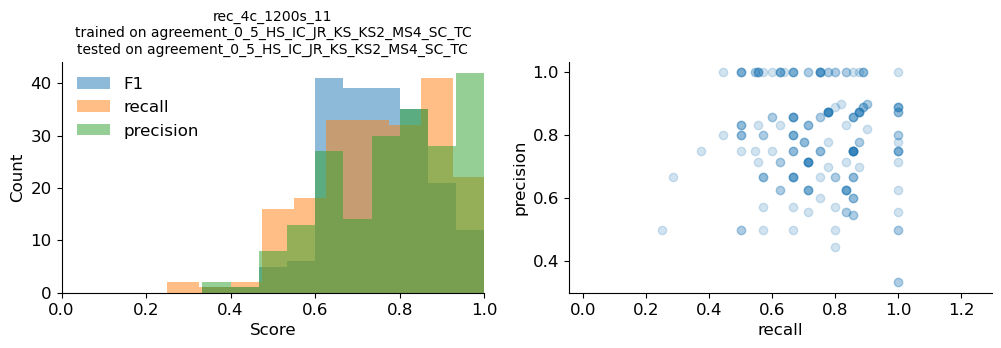

In [5]:
recording_train = recording_names[0]
recording_test = recording_names[0]

key1 = 'agreement_0_5_HS_IC_JR_KS_KS2_MS4_SC_TC'
# key1 = 'gt_comp_0_5'
train_sorters = None
test_sorter = None

model_metrics = []
for i in range(200):
    MP.create_train_test_split(select_test='single_recording', key=recording_train, random_state=i, verbose=False, test_size=.2)
    MP.fit(metrics, key1, solver="newton-cholesky", penalty='l2', C=1, oversample=False)
    y_pred = MP.predict()
    model_metrics.append(MP.get_model_metrics(y_pred, key1, sorter=test_sorter, print_stats=False))

plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.hist(np.array(model_metrics)[:,0], label='F1', alpha=.5);
plt.hist(np.array(model_metrics)[:,1], label='recall', alpha=.5);
plt.hist(np.array(model_metrics)[:,2], label='precision', alpha=.5);
plt.legend(frameon=False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel('Score')
plt.ylabel('Count')
plt.xlim(0,1)
plt.title(f'{recording_train}\ntrained on {key1}\ntested on {key1}', fontsize=10)
plt.subplot(1,2,2)
plt.scatter(np.array(model_metrics)[:,1], np.array(model_metrics)[:,2], alpha=.2)
plt.xlabel('recall')
plt.ylabel('precision')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.axis('equal');

In [12]:

recording_train = recording_names[0]
recording_test = recording_names[0]

key1 = 'agreement_0_5_HS_IC_JR_KS_KS2_MS4_SC_TC'
# key1 = 'gt_comp_0_5'
train_sorters = None
test_sorter = None

model_metrics = []
C_range = np.arange(0.01,2,0.02)
for C in C_range:
    m = []
    for i in range(20):
        MP.create_train_test_split(select_test='single_recording', key=recording_train, random_state=i, verbose=False, test_size=.2)
        MP.fit(metrics, key1, solver="newton-cholesky", penalty='l2', C=C, oversample=True)
        y_pred = MP.predict()
        m.append(MP.get_model_metrics(y_pred, key1, sorter=test_sorter, print_stats=False))
    model_metrics.append(m)
    
# plt.figure(figsize=(12,3))
# plt.subplot(1,2,1)
# plt.hist(np.array(model_metrics)[:,0], label='F1', alpha=.5);
# plt.hist(np.array(model_metrics)[:,1], label='recall', alpha=.5);
# plt.hist(np.array(model_metrics)[:,2], label='precision', alpha=.5);
# plt.legend(frameon=False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)
# plt.xlabel('Score')
# plt.ylabel('Count')
# plt.xlim(0,1)
# plt.title(f'{recording_train}\ntrained on {key1}\ntested on {key1}', fontsize=10)
# plt.subplot(1,2,2)
# plt.scatter(np.array(model_metrics)[:,1], np.array(model_metrics)[:,2], alpha=.2)
# plt.xlabel('recall')
# plt.ylabel('precision')
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)
# plt.axis('equal');

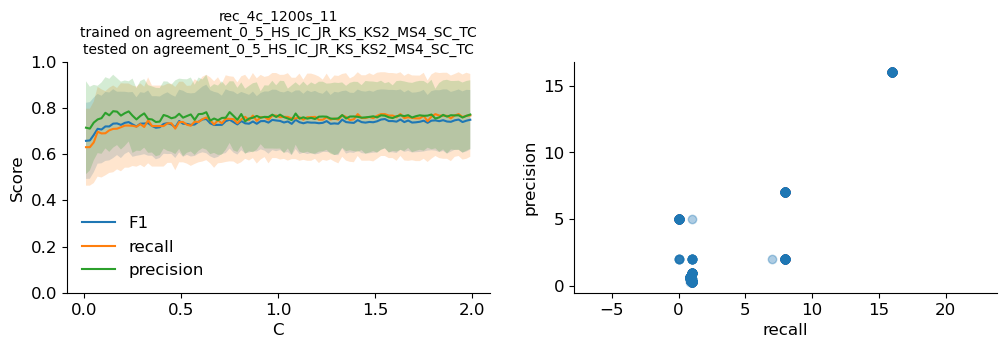

In [14]:
model_metrics = np.array(model_metrics)
model_metrics_mean = np.mean(model_metrics, axis=1)
model_metrics_std = np.std(model_metrics, axis=1)
# plot mean and std
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.plot(C_range, model_metrics_mean[:,0], label='F1');
plt.plot(C_range, model_metrics_mean[:,1], label='recall');
plt.plot(C_range, model_metrics_mean[:,2], label='precision');
plt.fill_between(C_range, model_metrics_mean[:,0]-model_metrics_std[:,0], model_metrics_mean[:,0]+model_metrics_std[:,0], alpha=.2)
plt.fill_between(C_range, model_metrics_mean[:,1]-model_metrics_std[:,1], model_metrics_mean[:,1]+model_metrics_std[:,1], alpha=.2)
plt.fill_between(C_range, model_metrics_mean[:,2]-model_metrics_std[:,2], model_metrics_mean[:,2]+model_metrics_std[:,2], alpha=.2)
plt.legend(frameon=False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel('C')
plt.ylabel('Score')
plt.ylim(0,1)
plt.title(f'{recording_train}\ntrained on {key1}\ntested on {key1}', fontsize=10)
plt.subplot(1,2,2)
plt.scatter(np.array(model_metrics)[:,1], np.array(model_metrics)[:,2], alpha=.2)
plt.xlabel('recall')
plt.ylabel('precision')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.axis('equal');


# recover ground truth from agreement in same recording - optimise model from ensemble

Text(0.5, 1.0, 'None\ntrained on agreement_0_5_HS_IC_JR_KS_KS2_MS4_SC_TC\ntested on gt_comp_0_5')

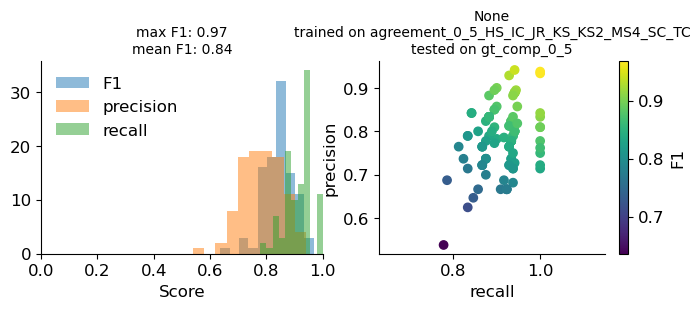

In [7]:
key1 = 'agreement_0_5_HS_IC_JR_KS_KS2_MS4_SC_TC'
key2 = 'gt_comp_0_5'
recording_train = recording_names[0]
recording_test = recording_names[0]
test_sorter = None
test_size = 0.5

# fit a model to predict agreements in the same recording on held-out neurons
model_metrics = []
for i in range(100):
    MP.create_train_test_split(select_test='single_recording', test_size=test_size, key=recording_train, random_state=i, verbose=False)
    MP.fit(metrics, key1, solver="newton-cholesky", penalty='l2', C=1)
    y_pred = MP.predict()
    model_metrics.append(MP.get_model_metrics(y_pred, key2, sorter=test_sorter, print_stats=False))

# get the best model
bestmodel = np.argmax(np.array(model_metrics)[:,0])
MP.create_train_test_split(select_test='single_recording', test_size=test_size, key=recording_train, random_state=bestmodel, verbose=False)
MP.fit(metrics, key1, solver="newton-cholesky", penalty='l2', C=1)

# test this model on the same recording, compare to ground truth
model_metrics = []
for i in range(100):
    MP.create_train_test_split(select_test='single_recording', test_size=test_size, key=recording_train, random_state=i, verbose=False)
    y_pred = MP.predict()
    model_metrics.append(MP.get_model_metrics(y_pred, key2, sorter=test_sorter, print_stats=False))

plt.figure(figsize=(8,2.5))
plt.subplot(1,2,1)
plt.hist(np.array(model_metrics)[:,0], label='F1', alpha=.5);
plt.hist(np.array(model_metrics)[:,1], label='precision', alpha=.5);
plt.hist(np.array(model_metrics)[:,2], label='recall', alpha=.5);
plt.xlabel('Score')
plt.legend(frameon=False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.title(f'max F1: {np.max(np.array(model_metrics)[:,0]):.2f}\nmean F1: {np.mean(np.array(model_metrics)[:,0]):.2f}', fontsize=10)
plt.xlim((0,1))
plt.subplot(1,2,2)
plt.scatter(np.array(model_metrics)[:,2], np.array(model_metrics)[:,1], alpha=1, c=np.array(model_metrics)[:,0])
plt.colorbar(label='F1')
plt.xlabel('recall')
plt.ylabel('precision')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.axis('equal')
plt.title(f'{test_sorter}\ntrained on {key1}\ntested on {key2}', fontsize=10);


# recover ground truth from agreement across recordings - optimise model from ensemble

In [8]:
recording_train = recording_names[1]
recording_test = recording_names[0]
key1 = 'agreement_0_5_HS_IC_JR_KS_KS2_MS4_SC_TC'
key2 = 'gt_comp_0_8'
test_sorter = None
test_size = 0.5
oversample = False

# fit a model to predict agreements in the same recording on held-out neurons
model_metrics = []
for i in range(100):
    MP.create_train_set(recording_names=[recording_train], train_size=1-test_size, random_state=i, verbose=False)
    MP.create_test_set(recording_names=[recording_test], verbose=False) 
    MP.fit(metrics, key1, solver="newton-cholesky", penalty='l2', C=1, oversample=oversample)
    y_pred = MP.predict()
    model_metrics.append(MP.get_model_metrics(y_pred, key2, sorter=test_sorter, print_stats=False))

# get the best model
bestmodel = np.argmax(np.array(model_metrics)[:,0])
MP.create_train_set(recording_names=[recording_train], train_size=1-test_size, random_state=bestmodel, verbose=False)
MP.create_test_set(recording_names=[recording_test], verbose=False) 
MP.fit(metrics, key1, solver="newton-cholesky", penalty='l2', C=1, oversample=oversample)

# test this model on a different recording, compare to ground truth
model_metrics = []
for i in range(200):
    MP.create_train_test_split(select_test='single_recording', test_size=test_size, key=recording_test, random_state=i, verbose=False)
    y_pred = MP.predict()
    model_metrics.append(MP.get_model_metrics(y_pred, key2, sorter=test_sorter, print_stats=False))

plt.figure(figsize=(8,2.5))
plt.subplot(1,2,1)
plt.hist(np.array(model_metrics)[:,0], label='F1', alpha=.5);
plt.hist(np.array(model_metrics)[:,1], label='precision', alpha=.5);
plt.hist(np.array(model_metrics)[:,2], label='recall', alpha=.5);
plt.xlabel('Score')
plt.legend(frameon=False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.title(f'train data:{recording_train}\ntest data:{recording_test}\nmax F1: {np.max(np.array(model_metrics)[:,0]):.2f}\nmean F1: {np.mean(np.array(model_metrics)[:,0]):.2f}', fontsize=10)
plt.xlim((0,1))
plt.subplot(1,2,2)
plt.scatter(np.array(model_metrics)[:,2], np.array(model_metrics)[:,1], alpha=1, c=np.array(model_metrics)[:,0])
plt.colorbar(label='F1')
plt.xlabel('recall')
plt.ylabel('precision')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.axis('equal')
plt.title(f'{test_sorter}\ntrained on {key1}\ntested on {key2}', fontsize=10)